#Praca domowa 3

###Inastalacja pakietów

In [1]:
!pip install shap captum torchinfo
!pip install timm

###Importowanie pakietów

In [2]:
import numpy as np 
import pandas as pd 
import os
import shap

In [3]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T 
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [4]:
import timm
from timm.loss import LabelSmoothingCrossEntropy 
from captum.attr import Lime
from skimage import segmentation
from captum.attr import IntegratedGradients
from captum.attr import KernelShap


In [5]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import sys
from tqdm import tqdm
import time
import copy

Funkcja 

In [8]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

Funkcja zwracająca loader i zbiór danych. Na wejściu funkcji podajemy ścieżkę do pliku oraz rozmiar batchów.

In [9]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "valid/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, val_data, test_data

##Zbiór danych Butterfly species

Pliki pobierane są z dysku Google.

In [10]:
dataset_path = "gdrive/MyDrive/butterfly-images40-species"

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Zbiór jest podzielany na treningowy, testowy i walidaycyjny. Zbiór treningowy składa się z 9285 obrazków podzielonych na 75 podzbiorów jeden dla każdego gatunku, a testowy i walidacyjny mają po 375 również podzielone na 75 podzbiorów i w każdym jest po 5 zdjęć danego gatunku. Każdy obrazek jest wymiaru 224x224 w formacie jpg w wersji RGB. 

In [12]:
(train_loader, train_data) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data, test_data) = get_data_loaders(dataset_path, 32, train=False)

In [13]:
train_data_len = len(train_data)
test_data_len = len(test_data)
valid_data_len = len(valid_data)

In [14]:
print(train_data_len) 
print(test_data_len)
print(valid_data_len) 

9285
375
375


Klasy na jakie podzielony jest zbiór:

In [15]:
classes = get_classes("gdrive/MyDrive/butterfly-images40-species/train/")
print(classes, len(classes))

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPER', 'QUESTION MARK', 'RED ADMIRA

In [16]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}
dataset = {
    "train": train_data,
    "val": valid_data
}

In [17]:
print(len(train_loader), len(val_loader), len(test_loader))

73 12 12


In [18]:
print(train_data_len, valid_data_len, test_data_len)

9285 375 375


In [19]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Załadowanie modelu EfficientNet-B0 trenowany na Butterfly

In [20]:
model = timm.create_model("efficientnet_b0", pretrained=True)


In [21]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.classifier)

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=75, bias=True)
)


In [23]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [24]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

##Trenowanie modelu

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=3) # now it is a lot faster
# I will come back after 10 epochs

Epoch 0/2
----------


100%|██████████| 73/73 [00:38<00:00,  1.91it/s]


train Loss: 2.6495 Acc: 0.5558


100%|██████████| 12/12 [00:02<00:00,  4.39it/s]


val Loss: 1.5268 Acc: 0.8053

Epoch 1/2
----------


100%|██████████| 73/73 [00:35<00:00,  2.04it/s]


train Loss: 1.5007 Acc: 0.8256


100%|██████████| 12/12 [00:01<00:00,  6.94it/s]


val Loss: 1.3271 Acc: 0.8800

Epoch 2/2
----------


100%|██████████| 73/73 [00:35<00:00,  2.03it/s]


train Loss: 1.3375 Acc: 0.8816


100%|██████████| 12/12 [00:01<00:00,  6.82it/s]

val Loss: 1.2510 Acc: 0.8987

Training complete in 1m 56s
Best Val Acc: 0.8987


Po wykonaniu 3 pętli uzyskano wynik 90% accuracy.

# Testowanie

In [27]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
    100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
))

100%|██████████| 12/12 [00:01<00:00,  6.55it/s]

Test Loss: 0.0966
Test Accuracy of ADONIS: 100% ( 5/ 5)
Test Accuracy of AFRICAN GIANT SWALLOWTAIL: 100% ( 5/ 5)
Test Accuracy of AMERICAN SNOOT: 80% ( 4/ 5)
Test Accuracy of AN 88: 100% ( 5/ 5)
Test Accuracy of APPOLLO: 100% ( 5/ 5)
Test Accuracy of ATALA: 100% ( 4/ 4)
Test Accuracy of BANDED ORANGE HELICONIAN: 100% ( 5/ 5)
Test Accuracy of BANDED PEACOCK: 100% ( 5/ 5)
Test Accuracy of BECKERS WHITE: 60% ( 3/ 5)
Test Accuracy of BLACK HAIRSTREAK: 100% ( 5/ 5)
Test Accuracy of BLUE MORPHO: 80% ( 4/ 5)
Test Accuracy of BLUE SPOTTED CROW: 75% ( 3/ 4)
Test Accuracy of BROWN SIPROETA: 100% ( 5/ 5)
Test Accuracy of CABBAGE WHITE: 100% ( 4/ 4)
Test Accuracy of CAIRNS BIRDWING: 80% ( 4/ 5)
Test Accuracy of CHECQUERED SKIPPER: 100% ( 5/ 5)
Test Accuracy of CHESTNUT: 75% ( 3/ 4)
Test Accuracy of CLEOPATRA: 75% ( 3/ 4)
Test Accuracy of CLODIUS PARNASSIAN: 75% ( 3/ 4)
Test Accuracy of CLOUDED SULPHUR: 100% ( 4/ 4)
Test Accuracy of COMMON BANDED AWL: 75% ( 3/ 4)
Test Accuracy of COMMON WOOD-NYMPH:

Accuracy na zbiorze testowym wynosi 87%.

##Wyjaśnienia klasyfikowanych zdjęć

In [50]:
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model.cpu(), example)
traced_script_module.save("butterfly_swin_transformer.pt")

In [51]:
images, labels = next(iter(train_loader))

In [53]:
from captum.attr import visualization

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )


In [43]:
def mask(image):
  return segmentation.slic(
    image.permute(1, 2, 0).mean(axis=2), 
    n_segments=100, 
    compactness=0.1, 
    start_label=0,
  )


Normalizowanie obrazków wejściowych

In [44]:
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

##Local interpretable model-agnostic explanations (LIME)

In [45]:
explainer = Lime(model)

In [54]:
def attr(i):
  return explainer.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(images[i])),
    show_progress=False
  )

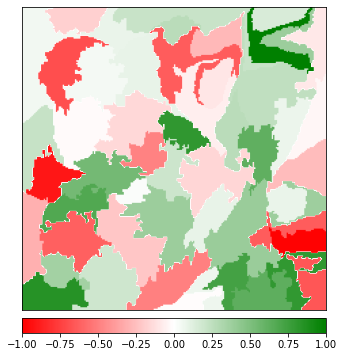

In [60]:
show_attr(attr(3)[0])

##Integrated Gradients (IG)

In [36]:
exp_ig = IntegratedGradients(model)

In [37]:
def attr_ig(i):
   return exp_ig.attribute(
       preprocess(images[i].unsqueeze(0)), target=labels[i])

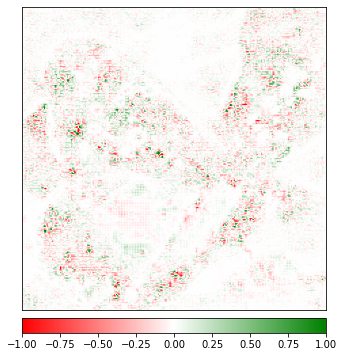

In [59]:
show_attr(attr_ig(3)[0])

## SHapley Additive exPlanations (SHAP)

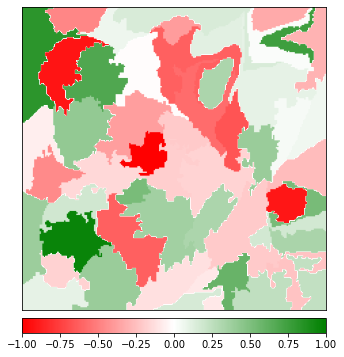

In [57]:
exp_ks = KernelShap(model)

def attr_ks(i):
  return exp_ks.attribute(
    preprocess(images[i].unsqueeze(0)), 
    target=labels[i], 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask(images[i])),
    show_progress=False
  )

show_attr(attr_ks(3)[0])


In [61]:
def show_image_mask_explanation(nums):
  for i in nums:
    fig, ax = plt.subplots(1, 5, figsize=[6 * 2, 6])
    ax[0].imshow(images[i].permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask(images[i]), cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(attr(i)[0].mean(axis=0), vmin=-1, vmax=1)
    ax[2].set_title("LIME")
    ax[3].imshow(attr_ig(i)[0].mean(axis=0), vmin=-1, vmax=1)
    ax[3].set_title("IG")
    ax[4].imshow(attr_ks(i)[0].mean(axis=0), vmin=-1, vmax=1)
    ax[4].set_title("SHAP")
    plt.show()
    

In [62]:
indexes = np.array([3, 23, 12, 1, 120])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


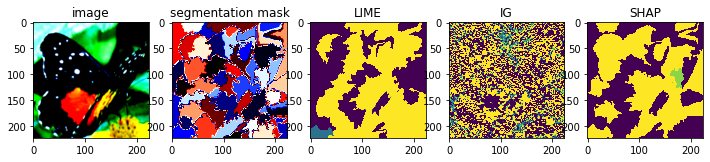

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


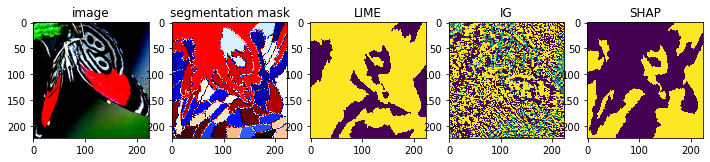

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


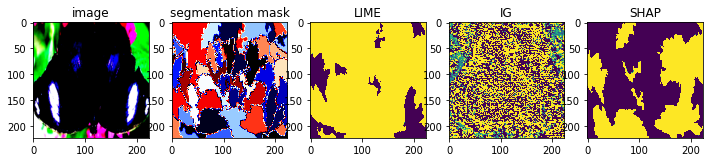

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


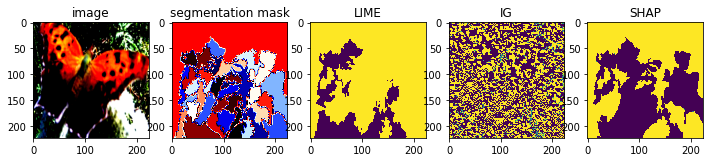

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


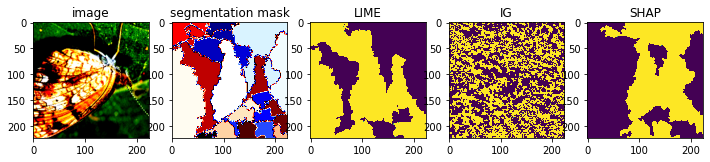

In [63]:
show_image_mask_explanation(indexes)

##Błędnie zakwalifikowane zdjęcia


  0%|          | 0/375 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


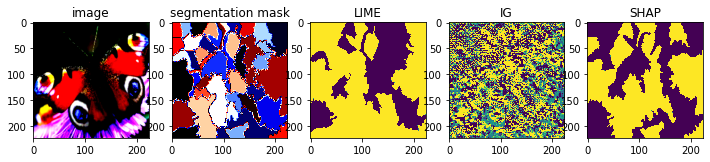


  0%|          | 1/375 [00:38<4:01:48, 38.79s/it]

Predict: ORANGE TIP, real: LARGE MARBLE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


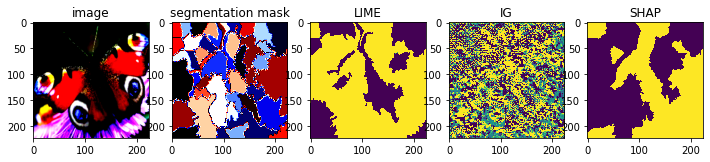


  1%|          | 2/375 [01:11<3:38:54, 35.21s/it]

Predict: PAPER KITE, real: MONARCH


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


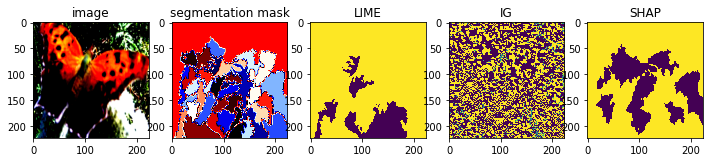

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: CRECENT, real: COPPER TAIL


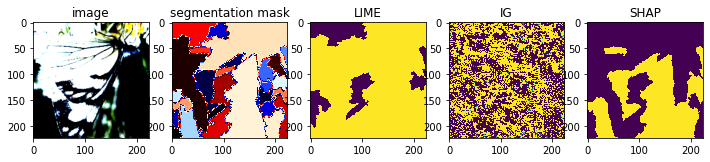

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: CHECQUERED SKIPPER, real: SILVER SPOT SKIPPER


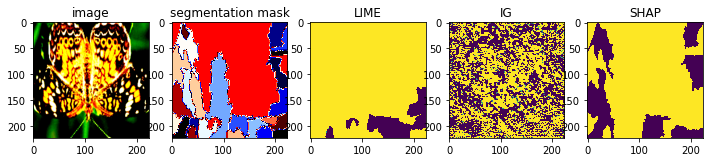


  1%|          | 3/375 [02:47<6:30:14, 62.94s/it]

Predict: COPPER TAIL, real: PURPLISH COPPER



  1%|▏         | 5/375 [02:50<2:35:33, 25.23s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


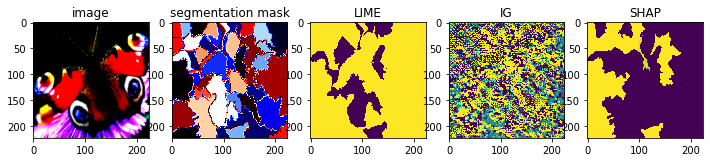

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: MALACHITE, real: IPHICLUS SISTER


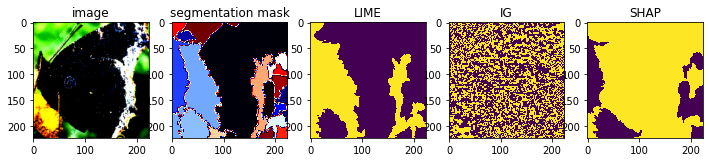


  2%|▏         | 6/375 [03:52<3:53:13, 37.92s/it]

Predict: POPINJAY, real: BLUE SPOTTED CROW



  2%|▏         | 8/375 [03:55<1:51:02, 18.15s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


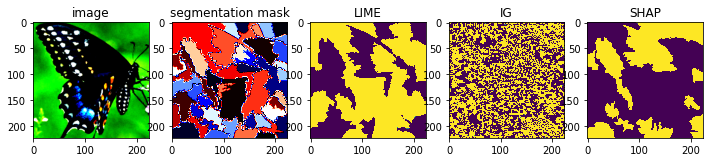

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: CLODIUS PARNASSIAN, real: EASTERN DAPPLE WHITE


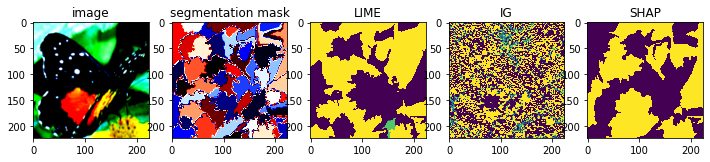


  2%|▏         | 9/375 [04:59<3:18:14, 32.50s/it]

Predict: LARGE MARBLE, real: BECKERS WHITE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


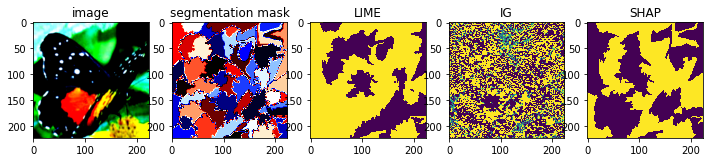

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: GREAT JAY, real: MALACHITE


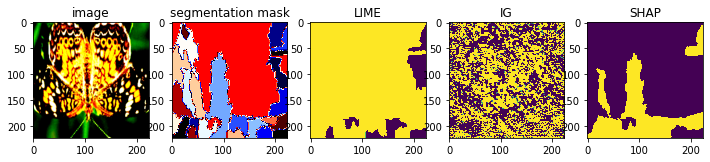


  3%|▎         | 10/375 [06:03<4:16:10, 42.11s/it]

Predict: SOUTHERN DOGFACE, real: SLEEPY ORANGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


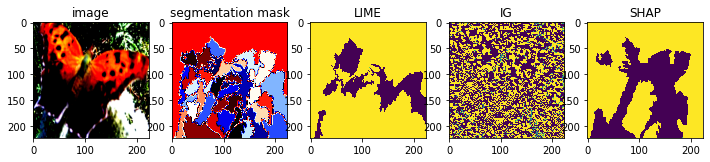

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: TWO BARRED FLASHER, real: PURPLISH COPPER


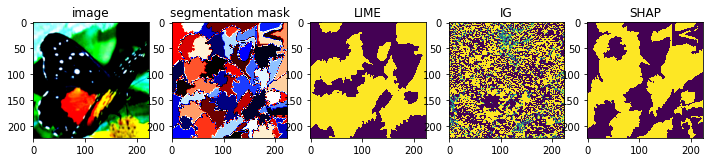

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: ULYSES, real: GREAT EGGFLY


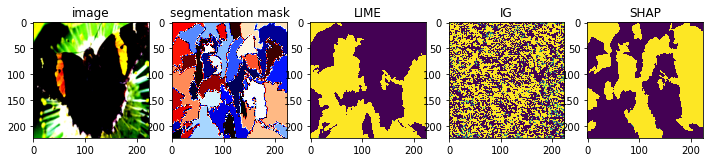

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: BECKERS WHITE, real: ELBOWED PIERROT


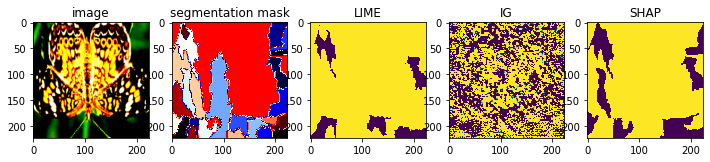


  3%|▎         | 11/375 [08:11<6:54:59, 68.40s/it]

Predict: COMMON WOOD-NYMPH, real: BLUE MORPHO


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


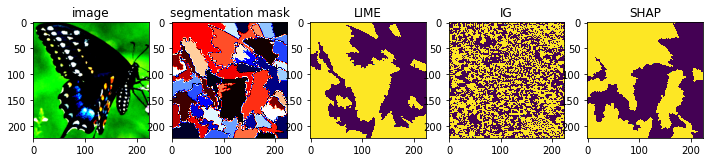

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict: GREAT EGGFLY, real: DANAID EGGFLY


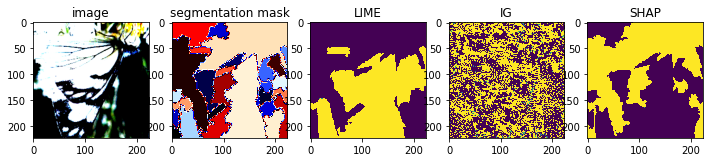


  3%|▎         | 12/375 [09:14<6:43:28, 66.69s/it]

Predict: BECKERS WHITE, real: LARGE MARBLE


  3%|▎         | 12/375 [09:14<4:39:28, 46.19s/it]


In [68]:
test_loss = 0.0
# model_ft.eval()
i = 0;
for data, target in tqdm(test_loader, total = test_data_len):
  with torch.no_grad(): 
      output = model_ft(data)
      loss = criterion(output, target)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))

  correct = np.squeeze(correct_tensor.cpu().numpy())
     
  for i in range(len(correct)):
    if(correct[i] == False):
      show_image_mask_explanation([i])
      print(f'Predict: {classes[pred[i]]}, real: {classes[target[i]]}')
    i = i+1
    if (i > 9):
      break
